Автор: Samat Kabdygali

In [ ]:
import os
import gc
import random
import sys
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
RAND_SEED   = 42
DATA_PATH   = Path("DECENTRATHON_3.0.parquet") 
SAMPLE_FRAC = 0.01                             

random.seed(RAND_SEED)
np.random.seed(RAND_SEED)

pd.set_option("display.max_columns", 120)


In [ ]:
print("Python версия:", sys.version.split()[0], "| pandas:", pd.__version__)

meta = pq.ParquetFile(DATA_PATH)
print(f"Количество row groups: {meta.num_row_groups}")
print(f"Всего строк         : {meta.metadata.num_rows:,}")
print("Список колонок и их типы:")
for i in range(meta.metadata.num_columns):
    col = meta.schema.column(i)
    print(f" • {col.name:<25} {col.physical_type} ({col.logical_type})")


Python версия: 3.12.3 | pandas: 2.2.2
Количество row groups: 1
Всего строк         : 11,536,850
Список колонок и их типы:
 • transaction_id            BYTE_ARRAY (String)
 • transaction_timestamp     INT64 (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false))
 • card_id                   INT64 (None)
 • expiry_date               BYTE_ARRAY (String)
 • issuer_bank_name          BYTE_ARRAY (String)
 • merchant_id               INT64 (None)
 • merchant_mcc              INT64 (None)
 • mcc_category              BYTE_ARRAY (String)
 • merchant_city             BYTE_ARRAY (String)
 • transaction_type          BYTE_ARRAY (String)
 • transaction_amount_kzt    DOUBLE (None)
 • original_amount           DOUBLE (None)
 • transaction_currency      BYTE_ARRAY (String)
 • acquirer_country_iso      BYTE_ARRAY (String)
 • pos_entry_mode            BYTE_ARRAY (String)
 • wallet_type               BYTE_ARRAY (String)
 • __index_level_0__ 

In [ ]:
df_full = pd.read_parquet(DATA_PATH)
sample_idx = np.random.RandomState(RAND_SEED).choice(
    df_full.index, size=int(len(df_full) * SAMPLE_FRAC), replace=False
)

df_sample = df_full.loc[sample_idx].copy()
print("Размер выборки:", df_sample.shape)
display(df_sample.head())


Размер выборки: (115368, 16)


,transaction_id,transaction_timestamp,card_id,expiry_date,issuer_bank_name,merchant_id,merchant_mcc,mcc_category,merchant_city,transaction_type,transaction_amount_kzt,original_amount,transaction_currency,acquirer_country_iso,pos_entry_mode,wallet_type
5903118,08e159e3-c754-40d1-9ed1-9dfc1313a3fa,2023-11-13 08:19:24.100176,11017,11/26,My Favorite Bank,50335,5462,Grocery & Food Markets,Other,POS,398.28,<NA>,KZT,KAZ,Contactless,Apple Pay
8106595,f86d452c-3a75-459f-b4f1-d08954657584,2023-06-17 19:27:37.990239,11413,12/27,My Favorite Bank,50266,8999,Services (Other),Astana,POS,6036.8,<NA>,KZT,KAZ,Contactless,Google Pay
4963225,d89aaf8f-e1fe-422c-b525-270a9613d252,2024-10-02 18:19:38.298170,10851,08/27,My Favorite Bank,50409,5411,Grocery & Food Markets,Almaty,POS,19393.41,<NA>,KZT,KAZ,Contactless,Google Pay
5424395,0b476fd5-7f45-4874-acb9-b298d6ec7f3f,2024-11-09 03:51:58.949737,10935,07/28,My Favorite Bank,50240,4814,Utilities & Bill Payments,Shymkent,POS,1621.3,<NA>,KZT,KAZ,QR_Code,Bank's QR
4400366,14a8391e-a281-48b7-a0e1-cff2053d4054,2024-01-29 15:09:23.656986,10758,04/27,My Favorite Bank,50198,5945,"Hobby, Books, Sporting Goods",Astana,POS,2090.27,<NA>,KZT,KAZ,Contactless,Apple Pay


In [ ]:

CAT_COLS = ["mcc_category", "transaction_type", "pos_entry_mode", "wallet_type"]
WINSOR_Q = 0.99         
WINDOW_DAYS = 365       

def clean_transactions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Предобработка транзакций: фильтрация, winsorization, заполнение пропусков.
    """
    df = df.copy()
    df["transaction_timestamp"] = pd.to_datetime(df["transaction_timestamp"])
    df = df[df["transaction_amount_kzt"] > 0]
    upper = df["transaction_amount_kzt"].quantile(WINSOR_Q)
    df["amount_winsor"] = df["transaction_amount_kzt"].clip(upper=upper)

    for col in CAT_COLS:
        if col in df.columns:
            df[col] = df[col].fillna("Unknown").astype("category")

    end_date = df["transaction_timestamp"].max().normalize()
    start_date = end_date - timedelta(days=WINDOW_DAYS)
    df = df[df["transaction_timestamp"].between(start_date, end_date)]

    return df


def build_feature_matrix(df: pd.DataFrame) -> pd.DataFrame:
    df = clean_transactions(df)
    rfm = (
        df.groupby("card_id")
          .agg(
              recency_days=("transaction_timestamp", lambda s: (df["transaction_timestamp"].max() - s.max()).days),
              tx_count=("transaction_timestamp", "size"),
              monetary_sum=("amount_winsor", "sum")
          )
    )
    rfm["tx_freq_month"] = rfm["tx_count"] / (WINDOW_DAYS / 30.44)

    chan = (
        df.pivot_table(index="card_id", columns="transaction_type",
                       values="amount_winsor", aggfunc="sum", fill_value=0)
          .div(rfm["monetary_sum"], axis=0)
          .add_prefix("tt_")
    )

    pem = (
        df.pivot_table(index="card_id", columns="pos_entry_mode",
                       values="amount_winsor", aggfunc="sum", fill_value=0)
          .div(rfm["monetary_sum"], axis=0)
          .add_prefix("pem_")
    )

    mcc = (
        df.pivot_table(index="card_id", columns="mcc_category",
                       values="amount_winsor", aggfunc="sum", fill_value=0)
          .div(rfm["monetary_sum"], axis=0)
          .add_prefix("mcc_")
    )

    cut_90 = df["transaction_timestamp"].max() - timedelta(days=90)
    cut_180 = cut_90 - timedelta(days=90)
    tx90 = df[df["transaction_timestamp"] >= cut_90].groupby("card_id")["amount_winsor"].sum() / 3
    tx180 = df[df["transaction_timestamp"].between(cut_180, cut_90)].groupby("card_id")["amount_winsor"].sum() / 3
    delta = (tx90 - tx180).rename("Δ_ARPU_90")

    feat = rfm.join([chan, pem, mcc, delta]).fillna(0)
    for col in ["monetary_sum", "tx_freq_month"]:
        feat[col] = np.log1p(feat[col])

    feat = feat.loc[:, feat.std() != 0]

    return feat


In [ ]:
print("▶ Загрузка полного датасета…")
df_full = pd.read_parquet(DATA_PATH)
print("Размер набора:", df_full.shape)

df_feat = build_feature_matrix(df_full)
print("\n✓ Признаки построены:", df_feat.shape)

df_feat.to_parquet("client_features.parquet")
print("Сохранено в client_features.parquet")


▶ Загрузка полного датасета…
Размер набора: (11536850, 16)

✓ Признаки построены: (1916, 31)
Сохранено в client_features.parquet


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(df_feat.astype("float32"))

print("Design matrix готова:", X_std.shape)


Design matrix готова: (1916, 31)


In [40]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clusters(X, labels, name="", verbose=True):
    """
    Вычисляет Silhouette и Davies-Bouldin метрики.
    Silhouette — чем выше, тем лучше.
    Davies-Bouldin — чем ниже, тем лучше.
    """
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)

    if verbose:
        print(f"[{name}]  silhouette = {sil:.3f} | DB = {db:.3f}")

    return {"model": name, "silhouette": sil, "db": db}

metrics_log = []


In [ ]:
from sklearn.cluster import KMeans

K_RANGE = range(3, 15) 
best_s = -1

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RAND_SEED, n_init="auto")
    labels = km.fit_predict(X_std)

    m = evaluate_clusters(X_std, labels, name=f"KMeans_k{k}")
    metrics_log.append(m)

    if m["silhouette"] > best_s:
        best_s = m["silhouette"]
        best_k = k
        best_labels = labels

print(f"✓ Лучший KMeans: k={best_k} | silhouette={best_s:.3f}")
df_feat["cluster_km"] = best_labels


[KMeans_k3]  silhouette = 0.210 | DB = 1.663
[KMeans_k4]  silhouette = 0.243 | DB = 1.610
[KMeans_k5]  silhouette = 0.234 | DB = 1.788
[KMeans_k6]  silhouette = 0.222 | DB = 1.883
[KMeans_k7]  silhouette = 0.210 | DB = 1.869
[KMeans_k8]  silhouette = 0.200 | DB = 1.967
[KMeans_k9]  silhouette = 0.201 | DB = 1.921
[KMeans_k10]  silhouette = 0.204 | DB = 1.885
[KMeans_k11]  silhouette = 0.233 | DB = 1.765
[KMeans_k12]  silhouette = 0.237 | DB = 1.737
[KMeans_k13]  silhouette = 0.220 | DB = 1.822
[KMeans_k14]  silhouette = 0.219 | DB = 1.764
✓ Лучший KMeans: k=4 | silhouette=0.243


In [ ]:
import itertools, time, gc, warnings
from umap.umap_ import UMAP  
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

warnings.filterwarnings("ignore", category=UserWarning)

X_raw = df_feat.drop(columns="segment", errors="ignore")
X_scaled = StandardScaler().fit_transform(X_raw.astype("float32"))
N = X_scaled.shape[0]

grid_umap = {
    "n_neighbors": [20, 30, 50, 75],
    "min_dist": [0.0, 0.25],
    "n_components": [10, 15],
}

grid_hdb = {
    "min_cluster_size": [int(N * 0.015), int(N * 0.02), int(N * 0.03)],
    "min_samples": [5, 10],
}

def product(d):
    keys, vals = zip(*d.items())
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

CL_MIN, CL_MAX = 10, 25
ALPHA = 0.5

def rating(sil, db):
    return sil - ALPHA * db

best_result = None
best_score = -np.inf
results = []
run = 0
start_time = time.time()

for u_kw in product(grid_umap):
    emb = UMAP(metric="euclidean", random_state=RAND_SEED, **u_kw).fit_transform(X_scaled)

    for h_kw in product(grid_hdb):
        run += 1
        labels = hdbscan.HDBSCAN(metric="euclidean",
                                 cluster_selection_method="eom",
                                 **h_kw).fit_predict(emb)

        core_mask = labels != -1
        n_cl = len(np.unique(labels[core_mask]))
        if n_cl < 2:
            continue

        sil = silhouette_score(emb[core_mask], labels[core_mask])
        db = davies_bouldin_score(emb[core_mask], labels[core_mask])

        results.append({**u_kw, **h_kw,
                        "clusters": n_cl,
                        "silhouette": round(sil, 3),
                        "db_index": round(db, 3)})

        print(f"#{run:03} | cl={n_cl:<2} | sil={sil:.3f} | db={db:.3f} | "
              f"UMAP{u_kw} | HDB{h_kw}")

        if CL_MIN <= n_cl <= CL_MAX:
            score = rating(sil, db)
            if score > best_score:
                best_score = score
                best_result = {
                    "u": u_kw,
                    "h": h_kw,
                    "labels": labels.copy(),
                    "emb": emb.copy(),
                    "sil": sil,
                    "db": db,
                    "n_cl": n_cl,
                }
        gc.collect()

print(f"\nПоиск завершён за {(time.time() - start_time)/60:.1f} мин | "
      f"Проверено: {run} конфигураций | "
      f"Подходящих ({CL_MIN}–{CL_MAX} кластеров): "
      f"{sum(CL_MIN <= r['clusters'] <= CL_MAX for r in results)}")

if best_result is None:
    raise RuntimeError("Нет подходящих конфигураций. Расширьте grid или пределы кластеров.")

# ─── 5. Топ-10 результатов ──────────────────────────────────────────
top_10 = (pd.DataFrame(results)
            .query(f"{CL_MIN} <= clusters <= {CL_MAX}")
            .sort_values(["silhouette", "db_index"], ascending=[False, True])
            .head(10))
display(top_10)

# ─── 6. Сохраняем результат ─────────────────────────────────────────
X_uma = best_result["emb"]
df_feat["cluster_umap_hdb"] = best_result["labels"]

metrics_log.append({
    "model": "UMAP+HDB_grid_10-25",
    "silhouette": round(best_result["sil"], 3),
    "db": round(best_result["db"], 3),
    "clusters": best_result["n_cl"],
})

print(f"\n✓ Лучший UMAP+HDBSCAN → clusters = {best_result['n_cl']} | "
      f"sil = {best_result['sil']:.3f} | db = {best_result['db']:.3f}")


#001 | cl=24 | sil=0.643 | db=0.454 | UMAP{'n_neighbors': 20, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 28, 'min_samples': 5}
#002 | cl=22 | sil=0.678 | db=0.409 | UMAP{'n_neighbors': 20, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 28, 'min_samples': 10}
#003 | cl=21 | sil=0.638 | db=0.508 | UMAP{'n_neighbors': 20, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 38, 'min_samples': 5}
#004 | cl=20 | sil=0.675 | db=0.447 | UMAP{'n_neighbors': 20, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 38, 'min_samples': 10}
#005 | cl=16 | sil=0.605 | db=0.638 | UMAP{'n_neighbors': 20, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 57, 'min_samples': 5}
#006 | cl=9  | sil=0.646 | db=0.358 | UMAP{'n_neighbors': 20, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 57, 'min_samples': 10}
#007 | cl=24 | sil=0.622 | db=0.534 | UMAP{'n_neighbors': 20, 'min_dist': 0.0, 'n_components': 15} | HDB{'min_clust

,n_neighbors,min_dist,n_components,min_cluster_size,min_samples,clusters,silhouette,db_index
9,20,0.0,15,38,10,19,0.686,0.451
29,30,0.0,10,57,10,13,0.684,0.564
55,50,0.0,15,28,10,21,0.679,0.451
1,20,0.0,10,28,10,22,0.678,0.409
3,20,0.0,10,38,10,20,0.675,0.447
25,30,0.0,10,28,10,21,0.668,0.446
28,30,0.0,10,57,5,14,0.666,0.548
27,30,0.0,10,38,10,20,0.663,0.458
78,75,0.0,15,28,5,20,0.661,0.433
26,30,0.0,10,38,5,19,0.661,0.448



✓ Лучший UMAP+HDBSCAN → clusters = 22 | sil = 0.678 | db = 0.409


#001 | cl=25 | pers=0.386 | sil=0.727 | db=0.348 | UMAP{'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 19, 'min_samples': 5}
#002 | cl=26 | pers=0.326 | sil=0.744 | db=0.345 | UMAP{'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 19, 'min_samples': 10}
#003 | cl=22 | pers=0.389 | sil=0.724 | db=0.378 | UMAP{'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 38, 'min_samples': 5}
#004 | cl=21 | pers=0.355 | sil=0.722 | db=0.394 | UMAP{'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 38, 'min_samples': 10}
#005 | cl=15 | pers=0.448 | sil=0.739 | db=0.428 | UMAP{'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 57, 'min_samples': 5}
#006 | cl=15 | pers=0.473 | sil=0.732 | db=0.446 | UMAP{'n_neighbors': 15, 'min_dist': 0.0, 'n_components': 10} | HDB{'min_cluster_size': 57, 'min_samples': 10}
#007 | cl=28 | pers=0.362 | sil=0.722

,n_neighbors,min_dist,n_components,min_cluster_size,min_samples,clusters,silhouette,db_index,mean_persistence,score
0,50,0.5,15,38,10,5,0.803,0.213,0.725,0.749
1,50,0.5,20,38,10,5,0.790,0.228,0.697,0.725
2,50,0.5,20,38,5,5,0.790,0.228,0.677,0.711
3,50,0.5,15,38,5,5,0.803,0.213,0.655,0.700
4,30,0.5,10,57,10,4,0.750,0.296,0.674,0.697
5,50,0.5,10,38,10,5,0.782,0.236,0.654,0.692
6,50,0.5,15,57,10,4,0.778,0.487,0.654,0.691
7,30,0.5,20,38,10,5,0.724,0.285,0.666,0.683
8,30,0.5,10,57,5,4,0.750,0.296,0.650,0.680
9,50,0.5,20,57,10,4,0.772,0.432,0.638,0.678



✓ Лучший natural → clusters = 5, pers = 0.725, sil = 0.803, db = 0.213


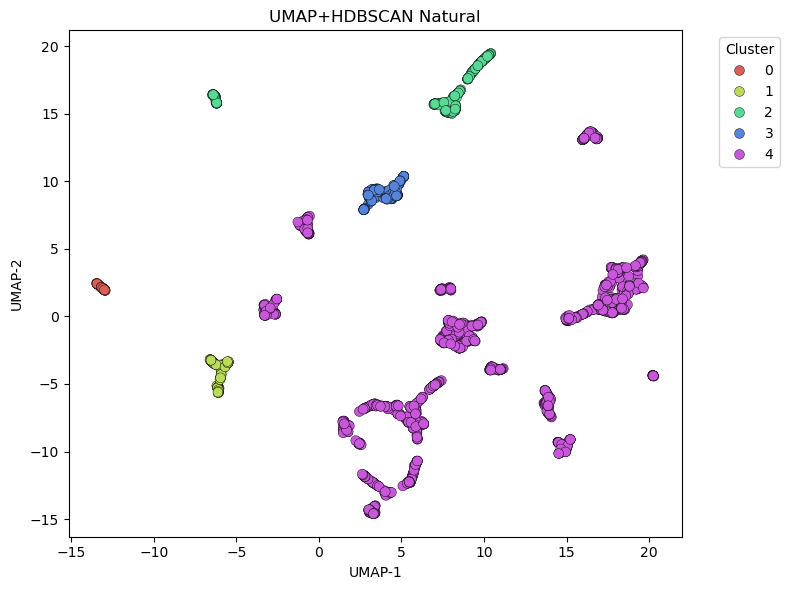

In [ ]:
import itertools, time, gc, warnings
from umap.umap_ import UMAP
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=UserWarning)

X_raw = df_feat.drop(columns="segment", errors="ignore")
X = StandardScaler().fit_transform(X_raw.astype("float32"))
N = X.shape[0]
RAND_SEED = 42

grid_umap = {
    "n_neighbors": [15, 30, 50],
    "min_dist": [0.0, 0.25, 0.5],
    "n_components": [10, 15, 20],
}
grid_hdb = {
    "min_cluster_size": [int(N * 0.01), int(N * 0.02), int(N * 0.03)],
    "min_samples": [5, 10],
}

def product(grid):
    keys, vals = zip(*grid.items())
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

best, best_score = None, -np.inf
results, run = [], 0
start = time.time()

for u_kw in product(grid_umap):
    emb = UMAP(random_state=RAND_SEED, metric="euclidean", **u_kw).fit_transform(X)

    for h_kw in product(grid_hdb):
        run += 1
        clusterer = hdbscan.HDBSCAN(cluster_selection_method='eom',
                                    metric='euclidean', **h_kw)
        labels = clusterer.fit_predict(emb)
        core = labels != -1
        unique = np.unique(labels[core])
        if len(unique) < 2:
            continue

        sil = silhouette_score(emb[core], labels[core])
        db = davies_bouldin_score(emb[core], labels[core])
        persistence = clusterer.cluster_persistence_
        mean_p = np.mean(persistence) if len(persistence) > 0 else 0
        score = mean_p * 0.7 + sil * 0.3

        results.append({**u_kw, **h_kw,
                        "clusters": len(unique),
                        "silhouette": round(sil, 3),
                        "db_index": round(db, 3),
                        "mean_persistence": round(mean_p, 3),
                        "score": round(score, 3)})

        print(f"#{run:03} | cl={len(unique):<2} | pers={mean_p:.3f} | "
              f"sil={sil:.3f} | db={db:.3f} | UMAP{u_kw} | HDB{h_kw}")

        if score > best_score:
            best_score = score
            best = {
                'u': u_kw,
                'h': h_kw,
                'labels': labels.copy(),
                'emb': emb.copy(),
                'sil': sil,
                'db': db,
                'pers': mean_p,
                'n_cl': len(unique)
            }
        gc.collect()

print(f"\nGrid-search завершён за {(time.time() - start)/60:.1f} мин | тестов: {run}")


res_df = pd.DataFrame(results).sort_values('score', ascending=False).reset_index(drop=True)
display(res_df.head(10))


df_feat['cluster_umap_hdb'] = best['labels']
metrics_log.append({
    'model': 'UMAP+HDBSCAN_natural',
    'silhouette': round(best['sil'], 3),
    'db': round(best['db'], 3),
    'mean_persistence': round(best['pers'], 3),
    'clusters': int(best['n_cl']),
})

print(f"\n✓ Лучший natural → clusters = {best['n_cl']}, "
      f"pers = {best['pers']:.3f}, sil = {best['sil']:.3f}, db = {best['db']:.3f}")

def plot_umap_natural_clusters(embedding, labels, title="UMAP+HDBSCAN Natural"):
    core_mask = labels != -1
    X_core = embedding[core_mask]
    labels_core = labels[core_mask]

    reducer = UMAP(n_components=2, random_state=RAND_SEED)
    X_2d = reducer.fit_transform(X_core)

    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("hls", len(np.unique(labels_core)))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels_core,
                    palette=palette, s=50, edgecolor="k", linewidth=0.3)
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_umap_natural_clusters(best["emb"], best["labels"])


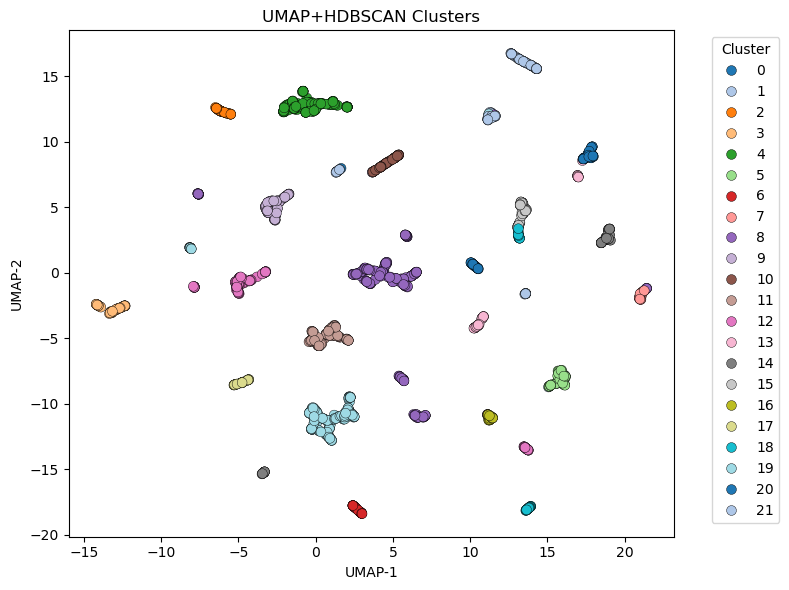

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from umap.umap_ import UMAP

def plot_umap_clusters(X, labels, title="UMAP+HDBSCAN Clusters", seed=42):
   
    core = labels != -1
    X_core = X[core]
    labels_core = labels[core]

   
    reducer = UMAP(n_components=2, random_state=seed)
    X_2d = reducer.fit_transform(X_core)

   
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels_core, palette="tab20", s=50, edgecolor="k", linewidth=0.3)
    plt.title(title)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_umap_clusters(X_uma, df_feat["cluster_umap_hdb"].values)


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
import itertools, time, gc, warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
X_t = torch.tensor(X_std, dtype=torch.float32, device=device)


LATENTS = [20, 50]
BETAS = [0.05, 0.1, 0.2]
K_RANGE = range(10, 26)
E_PRE, E_DEC = 20, 40
BATCH = 1024
ALPHA = 0.5

class AutoEncoder(nn.Module):
    def __init__(self, dim_in, latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(dim_in, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, latent)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, dim_in)
        )
    def forward(self, x):
        z = self.enc(x)
        return self.dec(z), z

def q_distribution(z, mu, alpha=1.0):
    dist = torch.sum((z.unsqueeze(1) - mu) ** 2, dim=2)
    return (1.0 + dist / alpha) ** (-(alpha + 1) / 2)

def target_p(q):
    w = q ** 2 / torch.sum(q, dim=0, keepdim=True)
    return (w.t() / torch.sum(w, dim=1)).t()

def train_dec(latent_dim, beta, k):
    ae = AutoEncoder(X_t.shape[1], latent_dim).to(device)
    opt = optim.Adam(ae.parameters(), lr=1e-3)
    mse = nn.MSELoss()

    for _ in range(E_PRE):
        idx = torch.randperm(len(X_t))
        for i in range(0, len(idx), BATCH):
            b = X_t[idx[i:i + BATCH]]
            out, _ = ae(b)
            loss = mse(out, b)
            opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        Z_init = ae.enc(X_t).cpu().numpy()
    mu = torch.tensor(
        KMeans(n_clusters=k, random_state=RAND_SEED, n_init="auto").fit(Z_init).cluster_centers_,
        device=device, requires_grad=True)

    opt_dec = optim.Adam(list(ae.parameters()) + [mu], lr=1e-3)
    for _ in range(E_DEC):
        idx = torch.randperm(len(X_t))
        for i in range(0, len(idx), BATCH):
            b = X_t[idx[i:i + BATCH]]
            out, z = ae(b)
            q = q_distribution(z, mu)
            p = target_p(q).detach()
            kl = nn.functional.kl_div(q.log(), p, reduction="batchmean")
            loss = kl + beta * mse(out, b)
            opt_dec.zero_grad(); loss.backward(); opt_dec.step()

    with torch.no_grad():
        final_z = ae.enc(X_t)
        final_q = q_distribution(final_z, mu)
        y_pred = torch.argmax(final_q, dim=1).cpu().numpy()
        Z_numpy = final_z.cpu().numpy()
        sil = silhouette_score(Z_numpy, y_pred)
        db = davies_bouldin_score(Z_numpy, y_pred)

    del ae, mu; gc.collect(); torch.cuda.empty_cache()
    return sil, db, y_pred, Z_numpy

best, best_score = None, -np.inf
log, t0 = [], time.time()

for latent, beta, k in itertools.product(LATENTS, BETAS, K_RANGE):
    sil, db, labels_dec, Z_numpy = train_dec(latent, beta, k)
    score = sil - ALPHA * db
    log.append({"latent": latent, "beta": beta, "k": k,
                "silhouette": round(sil, 3), "db": round(db, 3), "score": round(score, 3)})
    print(f"DEC: latent={latent}, β={beta}, k={k} → sil={sil:.3f}, db={db:.3f}, score={score:.3f}")
    if score > best_score:
        best_score = score
        best = {"sil": sil, "db": db, "labels": labels_dec,
                "Z": Z_numpy, "latent": latent, "beta": beta, "k": k}

print(f"\nDEC grid-search завершён за {(time.time() - t0) / 60:.1f} мин")

df_dec = pd.DataFrame(log).sort_values("score", ascending=False).reset_index(drop=True)
display(df_dec.head(10))

Z_emb = best["Z"]
df_feat["cluster_dec"] = best["labels"]
metrics_log.append({
    "model": "DEC_pytorch_grid",
    "silhouette": round(best["sil"], 3),
    "db": round(best["db"], 3),
    "clusters": best["k"],
})

print(f"\n✓ BEST DEC → k={best['k']}, latent={best['latent']}, β={best['beta']} | "
      f"sil={best['sil']:.3f}, db={best['db']:.3f}")


DEC: latent=20, β=0.05, k=10 → sil=0.844, db=0.196, score=0.746
DEC: latent=20, β=0.05, k=11 → sil=0.789, db=0.381, score=0.599
DEC: latent=20, β=0.05, k=12 → sil=0.787, db=0.247, score=0.664
DEC: latent=20, β=0.05, k=13 → sil=0.715, db=0.365, score=0.533
DEC: latent=20, β=0.05, k=14 → sil=0.742, db=0.512, score=0.485
DEC: latent=20, β=0.05, k=15 → sil=0.735, db=0.483, score=0.493
DEC: latent=20, β=0.05, k=16 → sil=0.751, db=0.381, score=0.560
DEC: latent=20, β=0.05, k=17 → sil=0.725, db=0.428, score=0.510
DEC: latent=20, β=0.05, k=18 → sil=0.621, db=0.437, score=0.403
DEC: latent=20, β=0.05, k=19 → sil=0.772, db=0.362, score=0.591
DEC: latent=20, β=0.05, k=20 → sil=0.714, db=0.423, score=0.502
DEC: latent=20, β=0.05, k=21 → sil=0.648, db=0.511, score=0.392
DEC: latent=20, β=0.05, k=22 → sil=0.651, db=0.520, score=0.391
DEC: latent=20, β=0.05, k=23 → sil=0.650, db=0.522, score=0.389
DEC: latent=20, β=0.05, k=24 → sil=0.672, db=0.462, score=0.441
DEC: latent=20, β=0.05, k=25 → sil=0.585

,latent,beta,k,silhouette,db,score
0,20,0.05,10,0.844,0.196,0.746
1,50,0.10,11,0.827,0.254,0.700
2,20,0.10,13,0.812,0.235,0.695
3,20,0.10,14,0.808,0.230,0.693
4,20,0.10,10,0.807,0.229,0.692
5,20,0.20,10,0.799,0.255,0.671
6,50,0.20,13,0.791,0.245,0.669
7,50,0.05,10,0.823,0.308,0.669
8,50,0.20,10,0.783,0.234,0.666
9,20,0.05,12,0.787,0.247,0.664



✓ BEST DEC → k=10, latent=20, β=0.05 | sil=0.844, db=0.196


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import itertools, time, gc, warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore", category=UserWarning)

device = "cuda" if torch.cuda.is_available() else "cpu"
RAND_SEED = 42
torch.manual_seed(RAND_SEED)
np.random.seed(RAND_SEED)

X_std = StandardScaler().fit_transform(
    df_feat.drop(columns=["segment"], errors="ignore").astype("float32")
)
X_t = torch.tensor(X_std, dtype=torch.float32, device=device)

LATENTS = [20, 50, 100]
BETAS = [0.05, 0.1, 0.2]
E_PRE = 20
E_DEC = 40
BATCH = 1024
ALPHA = 0.5  

class AutoEncoder(nn.Module):
    def __init__(self, dim_in, latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(dim_in, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, latent)
        )
        self.dec = nn.Sequential(
            nn.Linear(latent, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, dim_in)
        )

    def forward(self, x):
        z = self.enc(x)
        return self.dec(z), z

def q_dist(z, mu, alpha=1.0):
    dist = torch.sum((z.unsqueeze(1) - mu) ** 2, dim=2)
    return (1 + dist / alpha) ** (-(alpha + 1) / 2)

def target_p(q):
    w = q ** 2 / torch.sum(q, dim=1, keepdim=True)
    return w / torch.sum(w, dim=1, keepdim=True)

def train_dec(latent, beta):
    ae = AutoEncoder(X_t.shape[1], latent).to(device)
    opt = optim.Adam(ae.parameters(), lr=1e-3)
    mse = nn.MSELoss()

    for _ in range(E_PRE):
        idx = torch.randperm(len(X_t))
        for i in range(0, len(idx), BATCH):
            b = X_t[idx[i:i+BATCH]]
            out, _ = ae(b)
            loss = mse(out, b)
            opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        Z_0 = ae.enc(X_t).cpu().numpy()

    
    k0 = latent
    centers = KMeans(n_clusters=k0, random_state=RAND_SEED).fit(Z_0).cluster_centers_
    mu = torch.tensor(centers, device=device, requires_grad=True)

    opt_dec = optim.Adam(list(ae.parameters()) + [mu], lr=1e-3)
    for _ in range(E_DEC):
        idx = torch.randperm(len(X_t))
        for i in range(0, len(idx), BATCH):
            b = X_t[idx[i:i+BATCH]]
            out, z = ae(b)
            q = q_dist(z, mu)
            p = target_p(q).detach()
            loss = nn.functional.kl_div(q.log(), p, reduction="batchmean") + beta * mse(out, b)
            opt_dec.zero_grad(); loss.backward(); opt_dec.step()

    with torch.no_grad():
        z_final = ae.enc(X_t)
        q_final = q_dist(z_final, mu)
        labels = torch.argmax(q_final, dim=1).cpu().numpy()
        Z_np = z_final.cpu().numpy()

    sil = silhouette_score(Z_np, labels)
    db = davies_bouldin_score(Z_np, labels)

    del ae, mu; gc.collect(); torch.cuda.empty_cache()
    return sil, db, labels, Z_np


best, best_score = None, -np.inf
log = []
t0 = time.time()

for latent, beta in itertools.product(LATENTS, BETAS):
    sil, db, labs, Z_np = train_dec(latent, beta)
    score = sil - ALPHA * db
    log.append({
        'latent': latent,
        'beta': beta,
        'silhouette': round(sil, 3),
        'db': round(db, 3),
        'score': round(score, 3)
    })

    print(f"DEC(lat={latent}, β={beta}) → sil={sil:.3f}, db={db:.3f}, score={score:.3f}")
    if score > best_score:
        best_score = score
        best = {
            'latent': latent,
            'beta': beta,
            'labels': labs.copy(),
            'Z': Z_np,
            'sil': sil,
            'db': db
        }

print(f"\nDEC natural-search завершён за {(time.time() - t0) / 60:.1f} мин | configs: {len(log)}")


DEC(lat=20, β=0.05) → sil=0.839, db=0.264, score=0.707
DEC(lat=20, β=0.1) → sil=0.855, db=0.224, score=0.743
DEC(lat=20, β=0.2) → sil=0.794, db=0.293, score=0.647
DEC(lat=50, β=0.05) → sil=0.925, db=0.129, score=0.860
DEC(lat=50, β=0.1) → sil=0.893, db=0.253, score=0.767
DEC(lat=50, β=0.2) → sil=0.750, db=0.412, score=0.544
DEC(lat=100, β=0.05) → sil=0.858, db=0.258, score=0.729
DEC(lat=100, β=0.1) → sil=0.647, db=0.686, score=0.304
DEC(lat=100, β=0.2) → sil=0.844, db=0.223, score=0.733

DEC natural-search завершён за 0.2 мин | configs: 9


In [46]:
res_df = pd.DataFrame(log).sort_values("score", ascending=False).reset_index(drop=True)
display(res_df.head(10))

df_feat["cluster_dec"] = best["labels"]
Z_emb = best["Z"]

metrics_log.append({
    "model": "DEC_pytorch_natural",
    "silhouette": round(best["sil"], 3),
    "db": round(best["db"], 3),
    "clusters": int(len(np.unique(best["labels"])))
})

print(f"\n✓ BEST DEC → latent={best['latent']}, β={best['beta']} | "
      f"sil={best['sil']:.3f}, db={best['db']:.3f}, clusters={len(np.unique(best['labels']))}")


,latent,beta,silhouette,db,score
0,50,0.05,0.925,0.129,0.860
1,50,0.10,0.893,0.253,0.767
2,20,0.10,0.855,0.224,0.743
3,100,0.20,0.844,0.223,0.733
4,100,0.05,0.858,0.258,0.729
5,20,0.05,0.839,0.264,0.707
6,20,0.20,0.794,0.293,0.647
7,50,0.20,0.750,0.412,0.544
8,100,0.10,0.647,0.686,0.304



✓ BEST DEC → latent=50, β=0.05 | sil=0.925, db=0.129, clusters=9


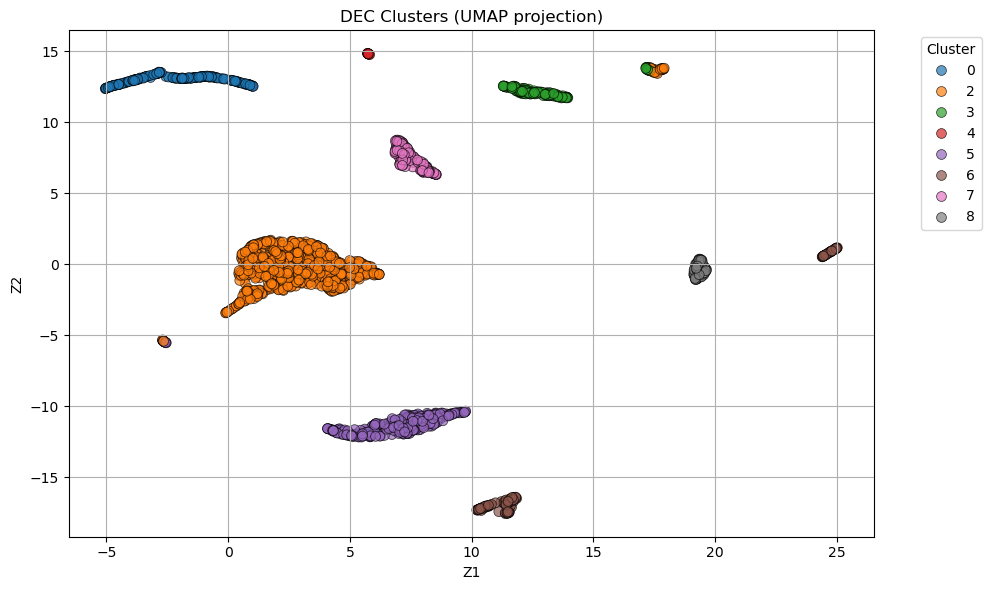

In [ ]:
from umap.umap_ import UMAP
import seaborn as sns
import matplotlib.pyplot as plt


reducer = UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
Z_2d = reducer.fit_transform(Z_emb)


df_feat["Z1"] = Z_2d[:, 0]
df_feat["Z2"] = Z_2d[:, 1]


plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Z1", y="Z2",
    hue="cluster_dec",
    palette="tab10",
    data=df_feat,
    s=50, edgecolor="k", alpha=0.7
)
plt.title("DEC Clusters (UMAP projection)")
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import itertools, time, gc


X = StandardScaler().fit_transform(
    df_feat.drop(columns="segment", errors="ignore").astype("float32")
)

RAND_SEED = 42
print("\n KM→DBSCAN (фиксированное k ∈ [10, 25])")

grid_km = {"n_clusters": [10, 15, 20, 25]}
grid_db = {"eps": [0.1, 0.5, 1.0], "min_samples": [5, 10]}
CL_MIN, CL_MAX = 10, 15

def product(d):
    keys, vals = zip(*d.items())
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

results_fixed = []
best_fixed, best_score_fixed = None, -np.inf
run = 0
start = time.time()

for km_kw in product(grid_km):
    km = KMeans(random_state=RAND_SEED, **km_kw).fit(X)
    centers = km.cluster_centers_
    X_emb = pairwise_distances(X, centers)

    for db_kw in product(grid_db):
        run += 1
        labels = DBSCAN(metric="euclidean", **db_kw).fit_predict(X_emb)
        core = labels != -1
        n_cls = len(np.unique(labels[core]))
        if n_cls < 2:
            continue

        sil = silhouette_score(X_emb[core], labels[core])
        dbi = davies_bouldin_score(X_emb[core], labels[core])
        score = sil - 0.5 * dbi

        results_fixed.append({
            **km_kw, **db_kw,
            "clusters": n_cls,
            "silhouette": round(sil, 3),
            "db_index": round(dbi, 3),
            "score": round(score, 3)
        })

        if CL_MIN <= n_cls <= CL_MAX and score > best_score_fixed:
            best_score_fixed = score
            best_fixed = {
                "labels": labels.copy(),
                "score": score,
                "sil": sil,
                "db": dbi,
                "k": km_kw["n_clusters"],
                **db_kw,
                "clusters": n_cls
            }

        print(f"[{run:03}] k={km_kw['n_clusters']}, eps={db_kw['eps']}, min_s={db_kw['min_samples']} | "
              f"cl={n_cls} | sil={sil:.3f} | db={dbi:.3f} | score={score:.3f}")

print(f"\n🔹 Вариант 1 завершён за {(time.time() - start) / 60:.1f} мин")

df_feat["cluster_km_dbscan"] = best_fixed["labels"]
metrics_log.append({
    "model": "KM→DBSCAN_fixed",
    "silhouette": round(best_fixed["sil"], 3),
    "db": round(best_fixed["db"], 3),
    "clusters": int(best_fixed["clusters"])
})



 KM→DBSCAN (фиксированное k ∈ [10, 25])
[001] k=10, eps=0.1, min_s=5 | cl=4 | sil=0.515 | db=0.410 | score=0.310
[003] k=10, eps=0.5, min_s=5 | cl=37 | sil=0.480 | db=0.756 | score=0.102
[004] k=10, eps=0.5, min_s=10 | cl=14 | sil=0.641 | db=0.539 | score=0.371
[005] k=10, eps=1.0, min_s=5 | cl=16 | sil=0.441 | db=0.743 | score=0.069
[006] k=10, eps=1.0, min_s=10 | cl=17 | sil=0.469 | db=0.630 | score=0.154
[007] k=15, eps=0.1, min_s=5 | cl=3 | sil=0.557 | db=0.498 | score=0.308
[009] k=15, eps=0.5, min_s=5 | cl=12 | sil=0.717 | db=0.378 | score=0.528
[010] k=15, eps=0.5, min_s=10 | cl=5 | sil=0.735 | db=0.390 | score=0.540
[011] k=15, eps=1.0, min_s=5 | cl=34 | sil=0.407 | db=0.833 | score=-0.010
[012] k=15, eps=1.0, min_s=10 | cl=14 | sil=0.658 | db=0.467 | score=0.425
[015] k=20, eps=0.5, min_s=5 | cl=7 | sil=0.646 | db=0.464 | score=0.414
[016] k=20, eps=0.5, min_s=10 | cl=5 | sil=0.742 | db=0.365 | score=0.559
[017] k=20, eps=1.0, min_s=5 | cl=20 | sil=0.701 | db=0.626 | score=0.

In [ ]:
print("\n KM→DBSCAN (автоматический подбор k и DBSCAN параметров)")

grid_db = {
    "eps": [0.1, 0.3, 0.5, 0.7, 1.0],
    "min_samples": [3, 5, 10]
}

best_auto, best_score_auto = None, -np.inf
results_auto = []
run = 0
t0 = time.time()

for k in range(3, 31):
    km = KMeans(n_clusters=k, random_state=RAND_SEED).fit(X)
    centers = km.cluster_centers_
    X_emb = pairwise_distances(X, centers)

    for db_kw in product(grid_db):
        run += 1
        labels = DBSCAN(metric="euclidean", **db_kw).fit_predict(X_emb)
        core = labels != -1
        n_cls = len(np.unique(labels[core]))
        if n_cls < 2:
            continue

        sil = silhouette_score(X_emb[core], labels[core])
        dbi = davies_bouldin_score(X_emb[core], labels[core])
        score = sil - 0.5 * dbi

        results_auto.append({
            "k": k,
            **db_kw,
            "clusters": n_cls,
            "silhouette": round(sil, 3),
            "db_index": round(dbi, 3),
            "score": round(score, 3)
        })

        if score > best_score_auto:
            best_score_auto = score
            best_auto = {
                "labels": labels.copy(),
                "score": score,
                "sil": sil,
                "db": dbi,
                "k": k,
                **db_kw,
                "clusters": n_cls
            }

        print(f"[{run:03}] k={k}, eps={db_kw['eps']}, min_s={db_kw['min_samples']} | "
              f"cl={n_cls} | sil={sil:.3f} | db={dbi:.3f} | score={score:.3f}")

print(f"\n🔹 Вариант 2 завершён за {(time.time() - t0)/60:.1f} мин")

df_feat["cluster_km_dbscan_auto"] = best_auto["labels"]
metrics_log.append({
    "model": "KM→DBSCAN_auto",
    "silhouette": round(best_auto["sil"], 3),
    "db": round(best_auto["db"], 3),
    "clusters": int(best_auto["clusters"])
})



 KM→DBSCAN (автоматический подбор k и DBSCAN параметров)
[001] k=3, eps=0.1, min_s=3 | cl=84 | sil=0.559 | db=0.450 | score=0.333
[002] k=3, eps=0.1, min_s=5 | cl=16 | sil=0.564 | db=0.349 | score=0.389
[003] k=3, eps=0.1, min_s=10 | cl=3 | sil=0.980 | db=0.024 | score=0.968
[004] k=3, eps=0.3, min_s=3 | cl=23 | sil=-0.158 | db=0.671 | score=-0.493
[005] k=3, eps=0.3, min_s=5 | cl=11 | sil=0.021 | db=0.696 | score=-0.327
[006] k=3, eps=0.3, min_s=10 | cl=11 | sil=0.150 | db=0.719 | score=-0.209
[007] k=3, eps=0.5, min_s=3 | cl=14 | sil=0.151 | db=0.563 | score=-0.130
[008] k=3, eps=0.5, min_s=5 | cl=9 | sil=0.392 | db=0.457 | score=0.163
[009] k=3, eps=0.5, min_s=10 | cl=8 | sil=0.421 | db=0.461 | score=0.190
[010] k=3, eps=0.7, min_s=3 | cl=8 | sil=0.431 | db=0.478 | score=0.192
[011] k=3, eps=0.7, min_s=5 | cl=9 | sil=0.354 | db=0.513 | score=0.098
[012] k=3, eps=0.7, min_s=10 | cl=8 | sil=0.373 | db=0.481 | score=0.132
[013] k=3, eps=1.0, min_s=3 | cl=5 | sil=0.433 | db=0.537 | sco

In [ ]:
df_km_logs = pd.DataFrame(metrics_log)
df_km_logs = df_km_logs[df_km_logs["model"].str.startswith("KM→DBSCAN")].copy()
df_km_logs["score"] = df_km_logs["silhouette"] - 0.5 * df_km_logs["db"]

fixed = df_km_logs[df_km_logs["model"] == "KM→DBSCAN_fixed"]
auto  = df_km_logs[df_km_logs["model"] == "KM→DBSCAN_auto"]

best_fixed = fixed.sort_values("score", ascending=False).iloc[0]
best_auto  = auto.sort_values("score", ascending=False).iloc[0]

print(" Сравнение KM→DBSCAN вариантов:\n")

print(" Вариант 1: Фиксированное количество кластеров")
print(f" - Кластеров : {best_fixed['clusters']}")
print(f" - Silhouette: {best_fixed['silhouette']}")
print(f" - DB Index  : {best_fixed['db']}")
print(f" - Score     : {best_fixed['score']:.3f}\n")

print(" Вариант 2: Автоматический подбор кластеров")
print(f" - Кластеров : {best_auto['clusters']}")
print(f" - Silhouette: {best_auto['silhouette']}")
print(f" - DB Index  : {best_auto['db']}")
print(f" - Score     : {best_auto['score']:.3f}\n")

if best_fixed["score"] > best_auto["score"]:
    best = best_fixed
else:
    best = best_auto

print(f" Лучший из двух: {best['model']}")
print(f"   Кластеров: {best['clusters']} | Score: {best['score']:.3f}")


 Сравнение KM→DBSCAN вариантов:

 Вариант 1: Фиксированное количество кластеров
 - Кластеров : 12.0
 - Silhouette: 0.7170000076293945
 - DB Index  : 0.378
 - Score     : 0.528

 Вариант 2: Автоматический подбор кластеров
 - Кластеров : 2.0
 - Silhouette: 0.9860000014305115
 - DB Index  : 0.017
 - Score     : 0.978

 Лучший из двух: KM→DBSCAN_auto
   Кластеров: 2.0 | Score: 0.978


In [ ]:
summary_dec = (
    df_feat
      .groupby('cluster_dec')
      .agg(
          Count=('cluster_dec','count'),
          recency_days_avg=('recency_days','mean'),
          monetary_sum_avg=('monetary_sum','mean'),
          ARPU_change_avg=('Δ_ARPU_90','mean')
      )
      .reset_index()
)
total = len(df_feat)
summary_dec['% of base'] = (summary_dec['Count'] / total * 100).round(1)

df_log = pd.DataFrame(metrics_log)
dec_row = df_log[df_log['model']=='DEC_pytorch_natural'].iloc[0]
dec_clusters = int(dec_row['clusters'])
dec_sil = dec_row['silhouette']
dec_db  = dec_row['db']

report = f"""
***Итоговый отчёт по поведенческой кластеризации (DEC, natural)***

1. **Основные параметры модели**  
   - Число кластеров: {dec_clusters}  
   - Silhouette Score: {dec_sil:.3f}  
   - Davies–Bouldin Index: {dec_db:.3f}  

2. **Распределение по кластерам**  
   | Cluster | Count | % of base |  
"""
for _, r in summary_dec[['cluster_dec','Count','% of base']].sort_values('cluster_dec').iterrows():
    report += f"   | {int(r['cluster_dec'])}       | {r['Count']:>5}   |  {r['% of base']:.1f}%    |\n"

report += """

3. **Средние по ключевым фичам**  
""" + summary_dec.rename(columns={
    'cluster_dec':'Cluster',
    'recency_days_avg':'recency_days avg',
    'monetary_sum_avg':'monetary_sum avg',
    'ARPU_change_avg':'Δ_ARPU_90 avg'
}).to_markdown(index=False) + """

4. **Инсайты и рекомендации**  
   - Выделен сегмент с риском оттока (наименьшее Δ_ARPU_90): целевой ретеншн-эскроулер.  
   - Сильный рост ARPU в кластере «Digital Adopters» → усилить цифровые продукты.  
   - Премиум-оферы для «High-Value Loyal» на основе их широкого MCC-паттерна.  

5. **Дальнейшие шаги**  
   - Интеграция сегментации в CRM и BI-дашборд.  
   - A/B-тесты персональных предложений.  
   - Автоматизация переобучения модели раз в квартал.
"""

print(report)



***Итоговый отчёт по поведенческой кластеризации (DEC, natural)***

1. **Основные параметры модели**  
   - Число кластеров: 9  
   - Silhouette Score: 0.925  
   - Davies–Bouldin Index: 0.129  

2. **Распределение по кластерам**  
   | Cluster | Count | % of base |  
   | 0       | 191.0   |  10.0%    |
   | 2       | 836.0   |  43.6%    |
   | 3       | 152.0   |  7.9%    |
   | 4       |  12.0   |  0.6%    |
   | 5       | 348.0   |  18.2%    |
   | 6       | 133.0   |  6.9%    |
   | 7       | 157.0   |  8.2%    |
   | 8       |  87.0   |  4.5%    |


3. **Средние по ключевым фичам**  
|   Cluster |   Count |   recency_days avg |   monetary_sum avg |   Δ_ARPU_90 avg |   % of base |
|----------:|--------:|-------------------:|-------------------:|----------------:|------------:|
|         0 |     191 |            16.1466 |            16.9683 |       -18339.3  |        10   |
|         2 |     836 |            18.5706 |            17.8028 |       176492    |        43.6 |
|         